<h1>Getting the MNIST dataset files</h1>

In this notebook we will mainly use the well-known MNIST handwritten digit dataset gather from http://yann.lecun.com/exdb/mnist/ 

In [1]:
import struct
import os
import sys
import numpy as np
import hashlib
import gzip
import random
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import itertools
from timeit import default_timer as timer
%matplotlib inline

In [2]:
 # Download utility function
def downloadProgressCallBack(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            sys.stderr.write("\n")
    else: # total size is unknown
        sys.stderr.write("read %d\n" % (readsofar,))

# File integrety checker
def md5Checksum(filename):
    md5 = hashlib.md5()
    with open(filename,'rb') as f: 
        for chunk in iter(lambda: f.read(8192), b''): 
            md5.update(chunk)
    return md5.hexdigest()

In [3]:
baseMNISTurl="http://yann.lecun.com/exdb/mnist/"
mnistDatasetFileNames = ["train-images-idx3-ubyte","train-labels-idx1-ubyte","t10k-images-idx3-ubyte","t10k-labels-idx1-ubyte"]
for fileNo in range(0,len(mnistDatasetFileNames)):
    if os.path.exists(mnistDatasetFileNames[fileNo]+".gz"):
        print(mnistDatasetFileNames[fileNo]+".gz" + ' is already exist')
    else:
        print('Downloading '+mnistDatasetFileNames[fileNo])
        urlretrieve(baseMNISTurl+mnistDatasetFileNames[fileNo]+".gz",mnistDatasetFileNames[fileNo]+".gz", downloadProgressCallBack)
        
        # Decompress .gz 
        with gzip.open(mnistDatasetFileNames[fileNo]+".gz", 'rb') as in_file:
            tempUncompressed = in_file.read()
            
        # Store uncompressed file
        with open(mnistDatasetFileNames[fileNo], 'wb') as f:
            f.write(tempUncompressed)
            

train-images-idx3-ubyte.gz is already exist
train-labels-idx1-ubyte.gz is already exist
t10k-images-idx3-ubyte.gz is already exist
t10k-labels-idx1-ubyte.gz is already exist


<h3>Parse dataset into numpy array</h3>

In [4]:
# MNIST dataser idx format parser 
# Code Snippet from : https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
def mnistParser(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [5]:
trainingImages = mnistParser(mnistDatasetFileNames[0])
trainingLabels = mnistParser(mnistDatasetFileNames[1])
testImages = mnistParser(mnistDatasetFileNames[2])
testLabels = mnistParser(mnistDatasetFileNames[3])

Now we have our dataset loaded in above variables as numpy array

In [6]:
print("Training Images Dimension:",trainingImages.shape)
print("Training Labels Dimension:",trainingLabels.shape)
print("Test Images Dimension:",testImages.shape)
print("Test Labels Dimenstion:",testLabels.shape)

Training Images Dimension: (60000, 28, 28)
Training Labels Dimension: (60000,)
Test Images Dimension: (10000, 28, 28)
Test Labels Dimenstion: (10000,)


Randomly pick and visualize some images

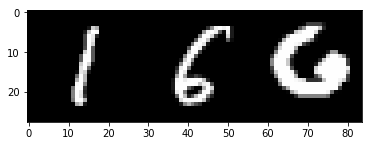

Class Label: 1 6 6


In [7]:
randomIdx = random.sample(range(trainingImages.shape[0]), 3)
randomImage = trainingImages[randomIdx,:,:].transpose(1,2,0)
concatRandomImage = np.concatenate((randomImage[:,:,0],randomImage[:,:,1],randomImage[:,:,2]),axis=1)
plt.figure()
plt.imshow(concatRandomImage[:,:],cmap='gray')
plt.show()
print('Class Label:',trainingLabels[randomIdx[0]],trainingLabels[randomIdx[1]],trainingLabels[randomIdx[2]])

Save the data to file for later used

In [8]:
np.savez('mnist.npz', trainingImages=trainingImages, trainingLabels=trainingLabels,testImages=testImages,testLabels=testLabels)

<h1> K-Nearest Neightbour </h1>
K-Nearest Neightbour is a simple non-parametric method used in many classification task. The main idea of this algorithm is very simple. We will pick the top k closest images from the training set, and have them vote on the label of the test image. Generally ,the higher values of k have a smoothing effect that makes the classifier more resistant to outliers.

Load dataset from existing npz file

In [9]:
loadNPZ = np.load('mnist.npz')
trainingImages = loadNPZ['trainingImages']
trainingLabels = loadNPZ['trainingLabels']
testImages = loadNPZ['testImages']
testLabels = loadNPZ['testLabels']
print("Training Images Dimension:",trainingImages.shape)
print("Training Labels Dimension:",trainingLabels.shape)
print("Test Images Dimension:",testImages.shape)
print("Test Labels Dimenstion:",testLabels.shape)

Training Images Dimension: (60000, 28, 28)
Training Labels Dimension: (60000,)
Test Images Dimension: (10000, 28, 28)
Test Labels Dimenstion: (10000,)


Reshape images array into 1-D vector (each row represents 1 image)

In [10]:
if len(trainingImages.shape) == 3 and len(testImages.shape) == 3:
    trainingImages = trainingImages.reshape(trainingImages.shape[0],trainingImages.shape[1]*trainingImages.shape[2])
    testImages = testImages.reshape(testImages.shape[0],testImages.shape[1]*testImages.shape[2])
print("Training Images Dimension:",trainingImages.shape)
print("Test Images Dimension:",testImages.shape)
testImages = testImages.astype(np.float32)
trainingImages = trainingImages.astype(np.float32)

Training Images Dimension: (60000, 784)
Test Images Dimension: (10000, 784)


In [11]:
def kNearestNeighbour(trainingImages,trainingLabels,testImages,k):

    if k%2 == 0:
        print("K must be odd")
        return
    if len(testImages.shape)!=2:
        print("testImage dimension should be (imageNo,featureLength) but get",testImages.shape)
        return
    # Pre-allocate the distance and output array
    computeDistance = np.zeros(trainingImages.shape[0]) 
    outputLabels = np.zeros(testImages.shape[0],dtype=np.uint8)
    # Iterate over each input test image
    for testImageNo in range(0,testImages.shape[0]):
        # Iterate over entire training set 
        if testImageNo % 10 == 0 and testImageNo !=0:
            print("Testing on ",testImageNo," from ",testImages.shape[0])
        # Faster implementation!    
        tempArr = np.tile(testImages[testImageNo],(trainingImages.shape[0],1))
        computeDistance =  np.linalg.norm(trainingImages - tempArr,axis=1)
        #for trainingImageNo in range(0,trainingImages.shape[0]):
            # Compute euclidence distance between test and training feature vector
        #    computeDistance[trainingImageNo] = np.linalg.norm(trainingImages[trainingImageNo] - testImages[testImageNo])
        # Sort computeDistance and kept sorted idx
        idx = np.argsort(computeDistance)
        # Pick top k closest image from training set and vote for the nearest label (mode!)
        pickIdx = idx[0:k]
        nearestLabel = np.argmax(np.bincount(trainingLabels[pickIdx]))
        outputLabels[testImageNo] = nearestLabel
    return outputLabels

Apply K Nearest Neighbour to first three elements in test set

In [12]:
outputLabels = kNearestNeighbour(trainingImages,trainingLabels,testImages[0:3,:],25)

Visualize the testing images and show their actual and predicted label

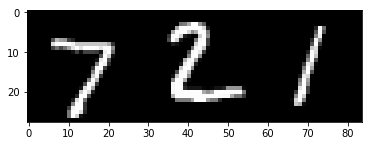

Actual Class Label: [7 2 1]
Predicted Class Label: [7 2 1]


In [13]:
testSampleImages = testImages[0:3,:].reshape(3,28,28)
concatImages = np.concatenate((testSampleImages[0,:,:],testSampleImages[1,:,:],testSampleImages[2,:,:]),axis=1)
plt.figure()
plt.imshow(concatImages,cmap='gray')
plt.show()
print('Actual Class Label:',testLabels[0:3])
print('Predicted Class Label:',outputLabels)

Running Test on first 100 elements

In [14]:
start = timer()
predictedLabels = kNearestNeighbour(trainingImages,trainingLabels,testImages[0:100],3)
end = timer()
singleThreadTime = end - start
print("Single Thread Processing Time: ",singleThreadTime," s")    

Testing on  10  from  100
Testing on  20  from  100
Testing on  30  from  100
Testing on  40  from  100
Testing on  50  from  100
Testing on  60  from  100
Testing on  70  from  100
Testing on  80  from  100
Testing on  90  from  100
Single Thread Processing Time:  18.112003962000017  s


Since single version of kNN is exteamly slow, we will try to implement multithread version using starmap

In [15]:
def map_kNearestNeighbour(trainingImages,trainingLabels,testImage,k):
    testImage = testImage.reshape(1,testImage.shape[0])
    if k%2 == 0:
        print("K must be odd")
        return
    if testImage.shape[0] !=1:
        print("Test image size inconsistence")
        return
    # Pre-allocate the distance and output array
    computeDistance = np.zeros(trainingImages.shape[0]) 
    outputLabels = np.zeros(testImage.shape[0],dtype=np.uint8)
    tempArr = np.tile(testImage,(trainingImages.shape[0],1))
    computeDistance =  np.linalg.norm(trainingImages - tempArr,axis=1)
    idx = np.argsort(computeDistance)
    # Pick top k closest image from training set and vote for the nearest label (mode!)
    pickIdx = idx[0:k]
    nearestLabel = np.argmax(np.bincount(trainingLabels[pickIdx]))
    outputLabels = nearestLabel
    return outputLabels

In [16]:
k = 3
pool = ThreadPool(4)
start = timer()
predictedLabelMulti = pool.starmap(map_kNearestNeighbour, zip(itertools.repeat(trainingImages),itertools.repeat(trainingLabels),testImages[0:100,:],itertools.repeat(k)))
predictedLabelMulti = np.array(predictedLabelMulti)
end = timer()
multiThreadTime = end - start
print("Multi Thread Processing Time: ",multiThreadTime," s") 
print("Speed gain x",singleThreadTime/multiThreadTime)

Multi Thread Processing Time:  14.70705829399958  s
Speed gain x 1.231517792337142


In [17]:
print("Predicted Result:",predictedLabelMulti)
print("Actual Result:",testLabels[0:100])
correct = (predictedLabelMulti == testLabels[0:100])
totalCorrect = np.sum(correct==True)
print("Total Correct:",totalCorrect)
print("Accuracy: ",(totalCorrect/100)*100,"%")

Predicted Result: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 9 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Actual Result: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Total Correct: 99
Accuracy:  99.0 %


Testing over entire test set (Caution!!: This will take a lot of time to run)

In [22]:
k = 3
pool = ThreadPool(4)
start = timer()
predictedLabelMulti = pool.starmap(map_kNearestNeighbour, zip(itertools.repeat(trainingImages),itertools.repeat(trainingLabels),testImages,itertools.repeat(k)))
predictedLabelMulti = np.array(predictedLabelMulti)
end = timer()
multiThreadTime = end - start
print("Multi Thread Processing Time: ",multiThreadTime," s") 

Multi Thread Processing Time:  1380.7558420460045  s


In [23]:
correct = (predictedLabelMulti == testLabels)
totalCorrect = np.sum(correct==True)
print("Total Correct:",totalCorrect)
print("Accuracy: ",(totalCorrect/testLabels.shape[0])*100,"%") 

Total Correct: 9705
Accuracy:  97.05 %


<h1>K Nearest Neightbour using sklearn</h1>
We already implemented k nearest neightbour from scatch. From now on we will try to use sklearn built-in knn function

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knnClassifier = KNeighborsClassifier(n_neighbors=3,algorithm="kd_tree");
knnClassifier.fit(trainingImages,trainingLabels);

Run speed test on 100 images

In [19]:
start = timer()
sklearnOutput = knnClassifier.predict(testImages[0:100,:])
end = timer()
sklearnTime = end - start
print(sklearnOutput)
print("Processing Time using sklearn: ",sklearnTime," s") 

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 9 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Processing Time using sklearn:  7.54623495299893  s


Run accuray test over entire test set

In [20]:
start = timer()
sklearnOutput = knnClassifier.predict(testImages)
end = timer()
sklearnTime = end - start
print("Processing Time using sklearn: ",sklearnTime," s") 

Processing Time using sklearn:  712.2936408200039  s


In [21]:
correct = (sklearnOutput == testLabels)
totalCorrect = np.sum(correct==True)
print("Total Correct:",totalCorrect)
print("Accuracy: ",(totalCorrect/testLabels.shape[0])*100,"%") 

Total Correct: 9705
Accuracy:  97.05 %


Plot a confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix

# Code From : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plotConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization


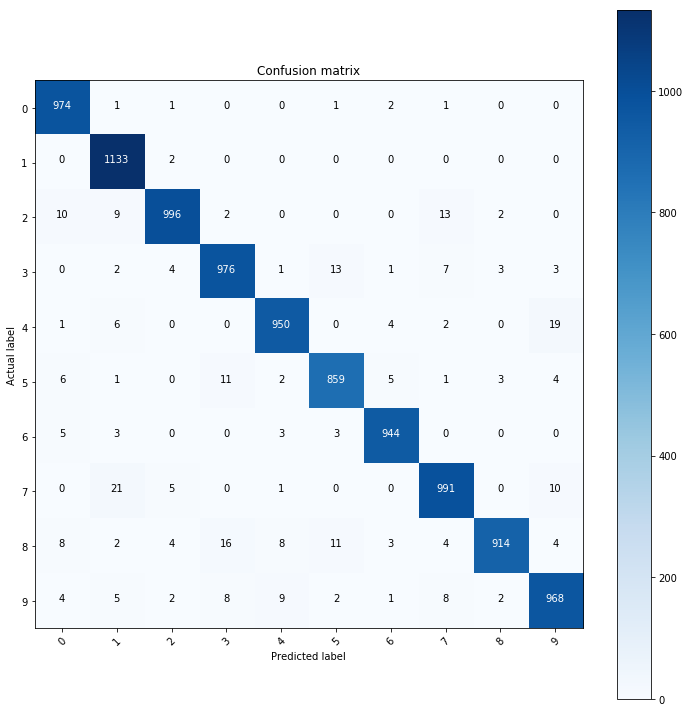

In [56]:
classLabels = [format(x,'d') for x in list(range(0,10))]
confusionMatrix = confusion_matrix(testLabels, sklearnOutput);
plotConfusionMatrix(confusionMatrix,classLabels)